# Coordinate frame conversions

Here are the most prominently-featured sources of documentation on the subject:

*   https://casa.nrao.edu/casadocs/casa-5.6.0/memo-series/reference-material/spectral-frames
*   https://help.almascience.org/index.php?/Knowledgebase/Article/View/86
*   https://casa.nrao.edu/docs/TaskRef/mstransform-task.html
*   https://casa.nrao.edu/casadocs/casa-5.4.1/uv-manipulation/manipulating-visibilities-with-mstransform
*   https://casa.nrao.edu/docs/TaskRef/cvel-task.html




The goal of this notebook is to demonstrate conversion of visibility and image data converted between spectral, spatial, and temporal reference frames using the next generation CASA infrastructure.

# Setting up


In [13]:
import os, time

start = time.time()
print("Installing fortran and CASA6 dependencies")
os.system("apt-get install libgfortran3")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
print(f"completed after {round(time.time() - start, 2)} seconds")
print("Installing ZINC")
os.system("pip install cngi-prototype==0.0.35")
print(f"completed after {round(time.time() - start, 2)} seconds")

Installing fortran and CASA6 dependencies
completed after 3.17 seconds
Installing ZINC
completed after 105.3 seconds


In [0]:
import numpy as np
import xarray as xr
import zarr
import cngi as zn

Note that we have not installed CASA6, so no tasks are available for use in this notebook.

## Data access

We don't need to download or convert any data if we use what's been previously converted and made available for download. We're going to accomplish that through the use of Simple Storage Service (S3) provided by Amazon Web Services.

This service provides a means of uploading and storing arbitrary data in the form of objects, accessible via web interface. `boto3` is the SDK provided by AWS to manage authentication and object access/manipulation.

In [0]:
import s3fs

This library allows us to register an object bucket in S3 with our python process as if it were a file system. This can be convenient for certain operations, and will allow us to treat the remotely-stored object data as if they were locally hosted file data.


In [0]:
# Initialize the S3 "file system"
s3 = s3fs.S3FileSystem(anon=True, requester_pays=False)

In [17]:
# Specify AWS S3 path
bucket = 'cngi-prototype-test-data/'

#ous, ddi = 'uid___A002_Xcad526_X4b6e', '27/'
#ous, ddi = 'uid___A002_Xcbc47c_Xe556', '5/'
ous, ddi = 'uid___A002_Xcfc232_X2eda', '16/'

dimension = 'chan'
#dimension = 'time'

contents = s3.listdir(bucket+ous+'_'+dimension+'_chunks.vis.zarr/'+ddi)
exists = s3.isdir(bucket+ous+'_'+dimension+'_chunks.vis.zarr/global/')

print(f"It is {exists} that these data can be accessed like files")
print(f"Here is an example object: {contents[0]}")

It is True that these data can be accessed like files
Here is an example object: {'Key': 'cngi-prototype-test-data/uid___A002_Xcfc232_X2eda_chan_chunks.vis.zarr/16/.zattrs', 'LastModified': datetime.datetime(2020, 1, 29, 18, 51, 20, tzinfo=tzlocal()), 'ETag': '"8e8e8993b89675494f89a2f7536106e1"', 'Size': 495, 'StorageClass': 'STANDARD', 'type': 'file', 'size': 495, 'name': 'cngi-prototype-test-data/uid___A002_Xcfc232_X2eda_chan_chunks.vis.zarr/16/.zattrs'}


Most of the objects we have uploaded to this bucket (so far) are zarr groups. [Zarr](https://zarr.readthedocs.io/en/stable/index.html) has been identified as a promising candidate library for managing the I/O component of our infrastructure in part because it was designed with features that allow it to reliably serve as a self-documenting, cloud-optimized array storage format. Access to this library's methods is exposed via the python standard libary's [MutableMapping](https://docs.python.org/3/library/collections.abc.html#collections.abc.MutableMapping) interface.

Let's open a zarr file that contains some calibrated visibility data.

In [0]:
s3_path = bucket+'test_data/sis14_twhya_field5_mstrans_lsrk.vis.zarr/'
ddi = "0"
s3_vis = s3_path+ddi
s3_md = s3_path+"global"

# Convert object stores to our desired MutableMapping interface
store_vis = s3fs.S3Map(root=s3_vis, s3=s3, check=False)
store_md = s3fs.S3Map(root=s3_md, s3=s3, check=False)

In [19]:
# We haven't opened anything, just created a big container of key-value pairs
print(store_md)

In [0]:
# Now we actually pass the mappings as input to xarray's zarr interface
vis_xds = xr.open_zarr(store=store_vis, consolidated=False)
global_xds = xr.open_zarr(store=store_md, consolidated=False)

#### To do: Extend cngi.dio.read_vis to handle this for us under the covers (recognize s3 URL and open up fsspec.mapping.FSMap objects)

And just like that we have a lazily-evaluated representation of our visibility group, which we can represent as an xarray dataset

In [33]:
print(vis_xds)

<xarray.Dataset>
Dimensions:        (baseline: 210, chan: 384, pair: 2, pol: 2, receptor: 2, spw: 1, time: 270, uvw_index: 3)
Coordinates:
    antennas       (baseline, pair) int32 dask.array<chunksize=(210, 2), meta=np.ndarray>
  * baseline       (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan           (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width     (chan) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    corr_product   (receptor, pol) int32 dask.array<chunksize=(2, 2), meta=np.ndarray>
    effective_bw   (chan) float64 dask.array<chunksize=(384,), meta=np.ndarray>
    field          (time) <U6 dask.array<chunksize=(270,), meta=np.ndarray>
    interval       (time) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    observation    (time) <U22 dask.array<chunksize=(270,), meta=np.ndarray>
  * pol            (pol) int32 9 12
    processor      (time) <U14 dask.array<chunksize=(270,), meta=np.ndarray>
    resolution     (ch

We also have access to the global properties of the observation

In [42]:
print(global_xds)

<xarray.Dataset>
Dimensions:                 (antenna: 26, d1: 1, d2: 2, d3: 3, feed: 1, field: 1, observation: 1, processor: 3, receptors: 3, source: 1, spw: 1, state: 20, time_fcmd: 5067, time_hist: 1137)
Coordinates:
  * antenna                 (antenna) int64 0 1 2 3 4 5 6 ... 20 21 22 23 24 25
  * feed                    (feed) int64 0
  * field                   (field) <U6 'TW Hya'
  * observation             (observation) <U22 'uid://A002/X327408/X6f'
  * processor               (processor) <U14 'CORRELATOR (0)' ... 'CORRELATOR (2)'
  * receptors               (receptors) int64 0 1 2
  * source                  (source) int32 0
  * spw                     (spw) int64 0
  * state                   (state) <U82 'CALIBRATE_BANDPASS#ON_SOURCE,CALIBRATE_PHASE#ON_SOURCE,CALIBRATE_WVR#ON_SOURCE (0)' ... 'OBSERVE_TARGET#ON_SOURCE (19)'
  * time_fcmd               (time_fcmd) float64 4.86e+09 4.86e+09 ... 4.86e+09
  * time_hist               (time_hist) float64 4.861e+09 ... 5.077e+09
D

In [39]:
print(len(global_xds.ASDM_chanFreq))

702


In [0]:
from cngi.vis import visualize

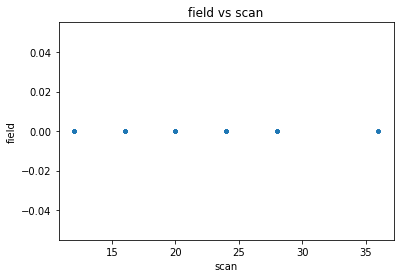

In [45]:
visualize(vis_xds.field, 'scan')